# raErr  decErr comparison

In https://sdm-schemas.lsst.io/dp1.html
raErr is defined as: "Error in right ascension". It is not explicitly specified whether raErr is the uncertainty at the source position (i.e. raErr*cos(dec)) or not.
If raErr is the uncertainty at the source position, I expect it to be comparable to decErr. If raErr is to be scaled with declination I expect it to be generally greater than decErr.

Io order to check if raErr already includes the factor *cos(dec), I did the following test, comparing raErr and decErr for a DP1 field at high declination (47 Tuc Globular Cluster  RA:6.02, Decl:-72.08, see https://dp1.lsst.io/overview/observations.html) to better see the effect of declination.
I checkef first disource coordinates error.


In [1]:
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from lsst.daf.butler import Butler
import lsst.sphgeom as sphgeom

## Data retriving

In [2]:
#47 Tuc Globular Cluster  6.02, -72.08
target_ra, target_dec, radius = 6.02, -72.08, 1.000  
#Extended Chandra Deep Field South (ECDFS)
#target_ra, target_dec, radius = 53.160, -28.100, 1.000   

t1 = Time("2024-12-01T00:00:00.0", format="isot", scale="tai")
t2 = Time("2024-12-11T00:00:00.0", format="isot", scale="tai")

print("t1=",t1.value," t2=",t2.value," range:", t2-t1, "[days]")

t1= 2024-12-01T00:00:00.000  t2= 2024-12-11T00:00:00.000  range: 10.0 [days]


In [3]:
butler = Butler("dp1", collections="LSSTComCam/DP1")

region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {target_ra} {target_dec} {radius}")
region_tracts = [t.id for t in butler.query_dimension_records(
    "tract",
    where="tract.region OVERLAPS :region",
    bind={"region": region}
)]

print(f"Overlapping tracts: {region_tracts}")

obj_refs = [*filter(
    lambda x: x.dataId["tract"] in region_tracts, 
    butler.query_datasets("object")
)]
objs_df =  pd.concat((butler.get(ref).to_pandas() for ref in obj_refs))
print(f"Found {len(objs_df)} objects")

sources_refs = [*filter(
    lambda x: x.dataId["tract"] in region_tracts, 
    butler.query_datasets("dia_source")
)]
sources_df = pd.concat((butler.get(ref).to_pandas() for ref in sources_refs))
print(f"Found {len(sources_df)} sources")

Overlapping tracts: [453, 454, 531, 532]
Found 115493 objects
Found 666698 sources



## Object filtering to clean the sample

In [4]:
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        len_before, len_before_cols = len(df), len(df.columns)

        df = func(df, *args, *kwargs)
        if (diff := len_before - len(df)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} rows ({100 * float(abs(diff / len_before)):.2f} %, originally: {len_before})")
        if (diff := len_before_cols - len(df.columns)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} columns (originally: {len_before_cols})")
        return df
    return msg_wrapper


flag_columns = [
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "centroid_flag",
    "apFlux_flag",
    "isDipole",
    # next flags are from Liu 2024
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_offimage",
    "pixelFlags_bad",
    "psfFlux_flag",
    "shape_flag",
]

def filter_flags(df: pd.DataFrame, flag_columns: list[str]) -> pd.DataFrame:
    for flag in flag_columns:
        def filter_func(df: pd.DataFrame, flag_name: str = flag) -> pd.DataFrame:
            return df[~df[flag_name]]
        
        filter_func.__name__ = f"filter_{flag}"
        df = verbose(filter_func)(df)
    return df
    

@verbose
def filter_nans(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["ra", "dec", "raErr", "decErr"])


# diaSource_df = filter_nans(filter_flags(diaSource_df))
sources_df = filter_nans(filter_flags(sources_df, flag_columns))

filter_pixelFlags_cr cut 1297 rows (0.19 %, originally: 666698)
filter_centroid_flag cut 136745 rows (20.55 %, originally: 665401)
filter_apFlux_flag cut 72 rows (0.01 %, originally: 528656)
filter_isDipole cut 301226 rows (56.99 %, originally: 528584)
filter_pixelFlags_saturated cut 313 rows (0.14 %, originally: 227358)
filter_pixelFlags_suspect cut 1746 rows (0.77 %, originally: 227045)
filter_pixelFlags_streak cut 7588 rows (3.37 %, originally: 225299)
filter_psfFlux_flag cut 810 rows (0.37 %, originally: 217711)
filter_shape_flag cut 83288 rows (38.40 %, originally: 216901)
filter_nans cut 3819 rows (2.86 %, originally: 133613)


In [5]:
@verbose
def filter_coorderr(df: pd.DataFrame, quantile: float)  -> pd.DataFrame:
    return df[
        (df["raErr"] < np.quantile(df["raErr"], quantile)) &
        (df["decErr"] < np.quantile(df["decErr"], quantile))
    ]

sources_df = filter_coorderr(sources_df, 0.95)

filter_coorderr cut 8589 rows (6.62 %, originally: 129794)


## raErr decErr comparison

I expected  raErr to be comparable to decErr if it included the factor cos(dec), or to become comparable to decErr after multiplyig it by cos(dec).

Surprisingly raErr appears to be comparable to decErr after being divided by cos(dec), as if it had been scaled twice by cos(dec).

The same effect id visible in the Extended Chandra Deep Field South (ECDFS), but much smaller because of the lower declinatio (-28.1 deg).

In [6]:
mask = (sources_df["raErr"] <= 0.002) & (sources_df["decErr"] <= 0.02)
_sources_df = sources_df[mask]

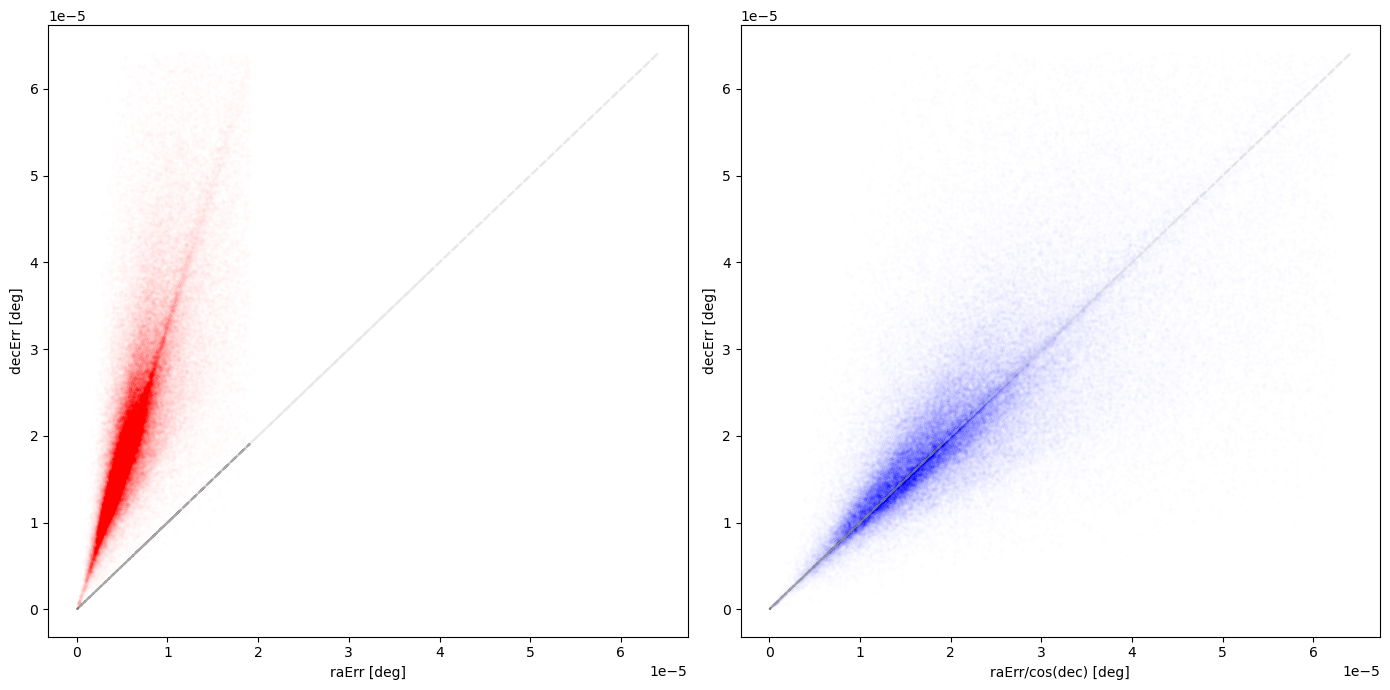

In [7]:
figure(figsize=(14, 7), dpi=100)
plt.subplot(1, 2, 1)
#identity line
plt.plot(_sources_df["raErr"],_sources_df["raErr"], color="black", linestyle='dashed', alpha=0.5) 
plt.plot(_sources_df["decErr"],_sources_df["decErr"], color="lightgray", linestyle='dashed', alpha=0.5) 
#data
plt.scatter(_sources_df["raErr"],_sources_df["decErr"], color="red", alpha=0.005, marker='o', s=5)
plt.xlabel ('raErr [deg]')
plt.ylabel ('decErr [deg]')

plt.subplot(1, 2, 2)
#identity line
plt.plot(_sources_df["raErr"],_sources_df["raErr"], color="black", linestyle= "dashed", alpha=0.5) 
plt.plot(_sources_df["decErr"],_sources_df["decErr"], color="lightgray", linestyle= "dashed", alpha=0.5) 
#data
plt.scatter(_sources_df["raErr"]/np.cos(np.radians(_sources_df["dec"])),_sources_df["decErr"], color="blue", alpha=0.005, marker='o', s=5)
plt.xlabel ('raErr/cos(dec) [deg]')
plt.ylabel ('decErr [deg]')
plt.tight_layout()
#plt.savefig("47Tuc_raErr_diaSource_check.jpg")
#plt.savefig("ECDFS_raErr_diaSource_check.jpg")
#plt.show()

# I do the same with the obiect coordinates (butler.query_datasets("object"))

In [8]:
#mask = (objs_df["coord_raErr"] <= 0.00005) & (objs_df["coord_decErr"] <= 0.00005)
#mask = (objs_df["coord_raErr"] <= 0.0002) & (objs_df["coord_decErr"] <= 0.0002)  #ECDFS
mask = (objs_df["coord_raErr"] <= 0.00002) & (objs_df["coord_decErr"] <= 0.00006)  #47Tuc
_objs_df = objs_df[mask]

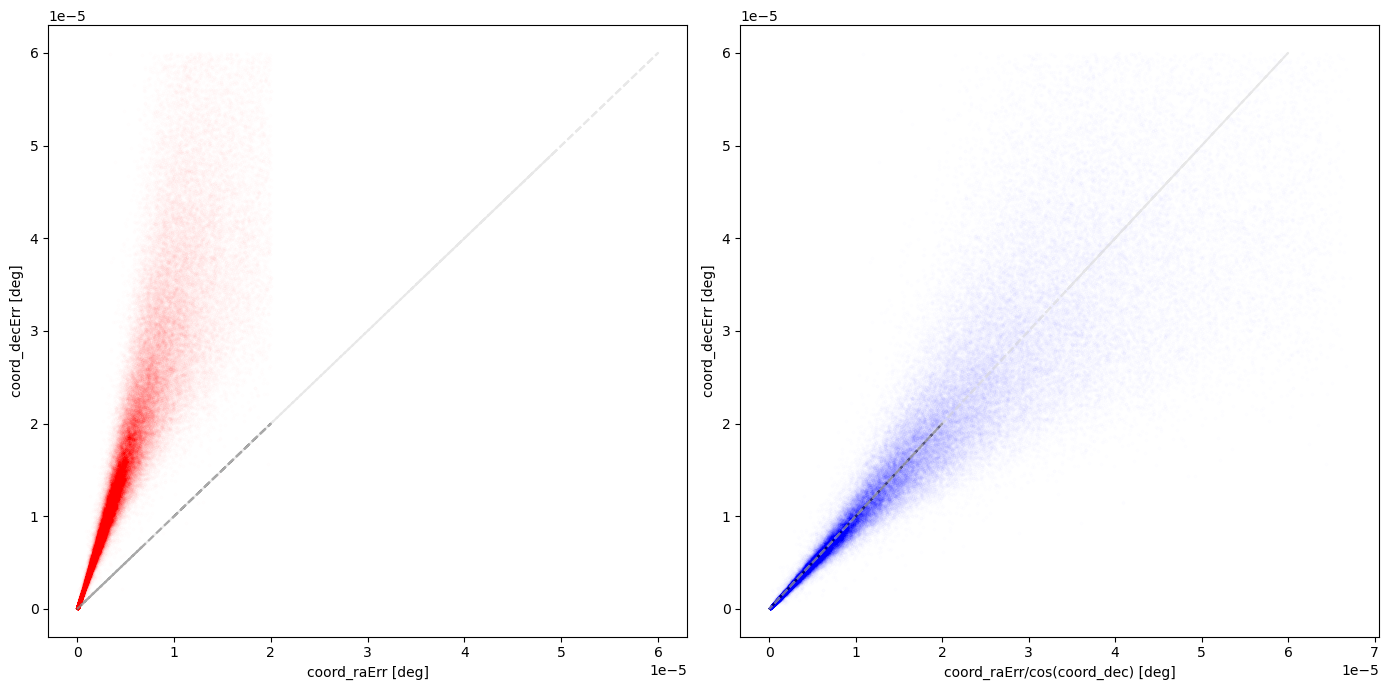

In [9]:
figure(figsize=(14, 7), dpi=100)
plt.subplot(1, 2, 1)
#identity line
plt.plot(_objs_df["coord_raErr"],_objs_df["coord_raErr"], color="black", linestyle='dashed', alpha=0.5) 
plt.plot(_objs_df["coord_decErr"],_objs_df["coord_decErr"], color="lightgray", linestyle='dashed', alpha=0.5) 
#data
plt.scatter(_objs_df["coord_raErr"],_objs_df["coord_decErr"], color="red", alpha=0.005, marker='o', s=5)
plt.xlabel ('coord_raErr [deg]')
plt.ylabel ('coord_decErr [deg]')

plt.subplot(1, 2, 2)
#identity line
plt.plot(_objs_df["coord_raErr"],_objs_df["coord_raErr"], color="black", linestyle= "dashed", alpha=0.5) 
plt.plot(_objs_df["coord_decErr"],_objs_df["coord_decErr"], color="lightgray", linestyle= "dashed", alpha=0.5) 
#data
plt.scatter(_objs_df["coord_raErr"]/np.cos(np.radians(_objs_df["coord_dec"])),_objs_df["coord_decErr"], 
            color="blue", alpha=0.005, marker='o', s=5)
plt.xlabel ('coord_raErr/cos(coord_dec) [deg]')
plt.ylabel ('coord_decErr [deg]')
plt.tight_layout()
plt.savefig("47Tuc_raErr_object_check.jpg")
#plt.savefig("ECDFS_raErr_object_check.jpg")
plt.show()